# Выбор локации для скважины

Предоставлены пробы нефти в трёх регионах: в каждом 100000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:
- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

_Условия задачи:
Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
Бюджет на разработку скважин в регионе — 10 млрд рублей.
При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью._

__План реализации проекта:__

- Цель - выбрать регион, в котором мы будем разрабатывать 200 новых скважин, т.к. выделенного бюджета хватает, чтобы получить признаки 500 месторождений, отобрать из них лучшие 200 и разработать их. 
- Чтобы понять, в каком регионе это лучше делать, мы моделируем в каждом регионе эту ситуацию, а именно: в каждом регионе у нас есть информация о 100 тыс. скважин, мы делим их на 75/25, на 75 строим модель; на оставшихся 25 тысячах пытаемся понять сколько мы заработаем. <div> 
- Для этого отбираем из этих 25 тысяч случайным образом 500, предсказываем количество нефти в этих скважинах, берем 200 лучших по предсказаниям и считаем сколько на самом деле мы добудем нефти.<div> 
- Это все мы делаем исходя из предположения, что распределение нефти в новых скважинах региона такое же, что и в тех информация о которых нам уже известна.

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st

from pandas.plotting import scatter_matrix

import matplotlib.pyplot as plt

import random

#from sklearn.tree import DecisionTreeClassifier
#from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression  

from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix

from sklearn.preprocessing import StandardScaler

from sklearn.dummy import DummyClassifier

from sklearn.utils import shuffle

from sklearn.metrics import precision_recall_curve, roc_curve

pd.set_option('display.max_columns', 40) #макс кол-во колонок в выводимых данных 
pd.set_option('display.max_rows', 20) #макс кол-во строк в выводимых данных
pd.set_option('display.width', 80) #макс кол-во символов в строке

%matplotlib inline

import warnings
warnings.simplefilter('ignore')

pd.options.mode.chained_assignment = None

## Загрузка и подготовка данных

In [2]:
try: 
    df0=pd.read_csv('/datasets/geo_data_0.csv')
    df1=pd.read_csv('/datasets/geo_data_1.csv')
    df2=pd.read_csv('/datasets/geo_data_2.csv')
    
except: 
    df0=pd.read_csv('datasets/geo_data_0.csv')
    df1=pd.read_csv('datasets/geo_data_1.csv')
    df2=pd.read_csv('datasets/geo_data_2.csv')

In [3]:
df0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [4]:
df1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [5]:
df2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [6]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [7]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [8]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [9]:
df0.corr()

,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


In [10]:
df1.corr()

,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


Видим сильную взаимосвязь между целевым признаком (product) и параметром f2.

In [11]:
df2.corr()

,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


Посмотрев на датасеты, видим, что данные обработаны, пропусков нет, признаки, судя по их виду, также уже обработаны и масштабированы, мультиколлинеарности между принзнаками нет, и можно создавать и обучать модель без дальнейшей работы по подготовке данных.  

## Обучение и проверка модели

Напишем функцию, которая разделит данные на обучающую и валидационную выборки, создаст и обучит модель, а также выведет среднее предсказанной значение, R2, RMSE и сформирует новый датасет, присоединив к нему данные прогноза. 

In [12]:
def lr_model_function (df): 
    features = df.drop(['product', 'id'], axis=1)
    target = df['product']

    features_train, features_valid, target_train, target_valid = train_test_split(
        features, target, test_size=0.25, random_state=12345) 

    model = LinearRegression()
    model.fit(features_train, target_train)

    predictions_valid = model.predict(features_valid)

    rmse_result=mean_squared_error(target_valid, predictions_valid)**0.5
    
    r2_result=model.score(features_valid, target_valid)

    df_mean_predicted_product=predictions_valid.mean()
    df_true_predicted_product=target_valid.mean()
    
    features_valid['predictions']=predictions_valid
    features_valid['true']=target_valid
    df_new=features_valid
    
    return (r2_result, rmse_result, df_mean_predicted_product, df_true_predicted_product, df_new, model)

Результатом функции станет кортеж из шести значений: <div>
- R2 модели линейной регрессии на валидационной выборке, <div>
- RMSE модели линейной регрессии на валидационной выборке, <div>
- Средний предсказанный запас сырья по региону, <div>
- Средний исследованный запас сырья по региону, <div>
- Датафрейм с предсказаниями, <div>
- Обученная нами модель. 

### Регион 1 - df0

In [13]:
print(*lr_model_function(df0), sep='\n')

0.27994321524487786
37.5794217150813
92.59256778438035
92.07859674082941
             f0        f1        f2  predictions        true
71751  0.948970 -0.057547  2.095727    95.894952   10.038645
80493  0.992974  0.206671 -0.142278    77.572583  114.551489
2655   1.199854 -0.563356 -1.852991    77.892640  132.603635
53233  0.691422 -0.433347  0.564974    90.175134  169.072125
91141  0.420772  0.972638  0.736190    70.510088  122.325180
...         ...       ...       ...          ...         ...
12581  1.841106 -0.107678  2.585648   103.037104  170.116726
18456  0.041859  0.489280  2.168001    85.403255   93.632175
73035  0.376389  1.054298 -0.430104    61.509833  127.352259
63834  1.071330 -0.470046  4.527099   118.180397   99.782700
43558  1.726318 -0.077871  5.007083   118.169392  177.821022

[25000 rows x 5 columns]
LinearRegression()


RMSE составляет более трети от среднего значения, и R2 метрика также говорит о незначительной точности нашей модели. 

Сохраним модель для региона в соответствующей переменной и сохраним датасет с предсказаниями по всей валидационной выборке. Также поступим в двуми другими регионами. 

In [14]:
model0=lr_model_function(df0)[-1]
df0_result=lr_model_function(df0)[-2]
df0_result

,f0,f1,f2,predictions,true
71751,0.948970,-0.057547,2.095727,95.894952,10.038645
80493,0.992974,0.206671,-0.142278,77.572583,114.551489
2655,1.199854,-0.563356,-1.852991,77.892640,132.603635
53233,0.691422,-0.433347,0.564974,90.175134,169.072125
91141,0.420772,0.972638,0.736190,70.510088,122.325180
...,...,...,...,...,...
12581,1.841106,-0.107678,2.585648,103.037104,170.116726
18456,0.041859,0.489280,2.168001,85.403255,93.632175
73035,0.376389,1.054298,-0.430104,61.509833,127.352259
63834,1.071330,-0.470046,4.527099,118.180397,99.782700


Также посмотрим на графики плотностей распределения целевого признака и результатов предсказаний. 

<AxesSubplot:>

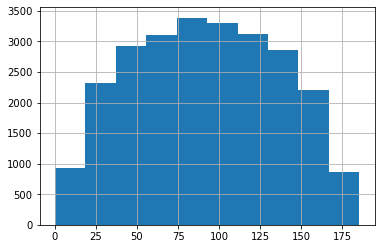

In [15]:
df0_result['true'].hist(bins=10)

<AxesSubplot:>

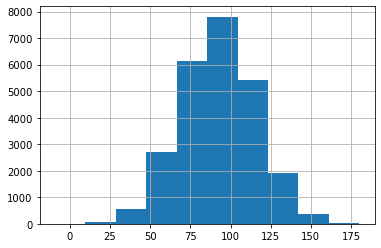

In [16]:
df0_result['predictions'].hist(bins=10)

Несмотря на невысокую разницу в найденных средних, видим, что фактические распределения различаются, и метрики модели невысоки. 

### Регион 2 - df1

In [17]:
print(*lr_model_function(df1), sep='\n')

0.9996233978805127
0.8930992867756166
68.728546895446
68.72313602437494
              f0         f1        f2  predictions        true
71751  -0.371866  -1.862494  3.002210    82.663314   80.859783
80493   9.015122 -13.881455  1.995363    54.431786   53.906522
2655   -6.507568  -4.817448  1.003449    29.748760   30.132364
53233  14.560845 -10.667755  1.995175    53.552133   53.906522
91141   6.090476  -4.494723  0.013815     1.243856    0.000000
...          ...        ...       ...          ...         ...
12581  -4.107455  -4.607004  4.991140   136.869211  137.945408
18456  -8.363585  -6.357527  3.995592   110.693465  110.992147
73035  -9.136241  -5.403258  5.000925   137.879341  137.945408
63834  -6.386442  -0.764568  3.011526    83.761966   84.038886
43558  10.542817  -6.206446  1.992290    53.958466   53.906522

[25000 rows x 5 columns]
LinearRegression()


Видим, что показатели метрик RMSE и R2 очень хороши. Это, очевидно, из-за найденной нами сильной корреляции между result и параметром f2 в этом датасете, который мы увидели ранее. 

In [18]:
model1=lr_model_function(df1)[-1]
df1_result=lr_model_function(df1)[-2]
df1_result

,f0,f1,f2,predictions,true
71751,-0.371866,-1.862494,3.002210,82.663314,80.859783
80493,9.015122,-13.881455,1.995363,54.431786,53.906522
2655,-6.507568,-4.817448,1.003449,29.748760,30.132364
53233,14.560845,-10.667755,1.995175,53.552133,53.906522
91141,6.090476,-4.494723,0.013815,1.243856,0.000000
...,...,...,...,...,...
12581,-4.107455,-4.607004,4.991140,136.869211,137.945408
18456,-8.363585,-6.357527,3.995592,110.693465,110.992147
73035,-9.136241,-5.403258,5.000925,137.879341,137.945408
63834,-6.386442,-0.764568,3.011526,83.761966,84.038886


<AxesSubplot:>

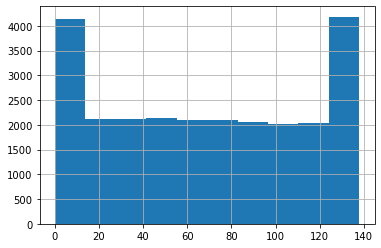

In [19]:
df1_result['true'].hist(bins=10)

<AxesSubplot:>

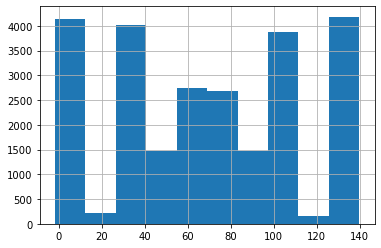

In [20]:
df1_result['predictions'].hist(bins=10)

Несмотря на хорошие метрики модели, видим, что фактические распределения значений по группам различаются.

### Регион 3 - df2

In [21]:
print(*lr_model_function(df2), sep='\n')

0.20524758386040443
40.02970873393434
94.96504596800489
94.88423280885489
             f0        f1        f2  predictions        true
71751 -1.444717 -3.861599  2.225805    93.599633   61.212375
80493 -1.418617  1.276544 -0.976433    75.105159   41.850118
2655  -4.587649 -0.413199  1.649268    90.066809   57.776581
53233  1.871584  1.619101  4.273555   105.162375  100.053761
91141 -2.028785  4.128167  6.089547   115.303310  109.897122
...         ...       ...       ...          ...         ...
12581 -1.315037 -0.122572 -0.345986    78.765887   28.492402
18456  0.015144  0.876998  2.603666    95.603394   21.431303
73035  0.725767 -0.151545  3.258620    99.407281  125.487229
63834 -0.232209 -0.180354 -0.524997    77.779912   99.422903
43558 -2.350293 -1.041230  8.458378   129.032417  127.445075

[25000 rows x 5 columns]
LinearRegression()


In [22]:
model2=lr_model_function(df2)[-1]
df2_result=lr_model_function(df2)[-2]
df2_result

,f0,f1,f2,predictions,true
71751,-1.444717,-3.861599,2.225805,93.599633,61.212375
80493,-1.418617,1.276544,-0.976433,75.105159,41.850118
2655,-4.587649,-0.413199,1.649268,90.066809,57.776581
53233,1.871584,1.619101,4.273555,105.162375,100.053761
91141,-2.028785,4.128167,6.089547,115.303310,109.897122
...,...,...,...,...,...
12581,-1.315037,-0.122572,-0.345986,78.765887,28.492402
18456,0.015144,0.876998,2.603666,95.603394,21.431303
73035,0.725767,-0.151545,3.258620,99.407281,125.487229
63834,-0.232209,-0.180354,-0.524997,77.779912,99.422903


<AxesSubplot:>

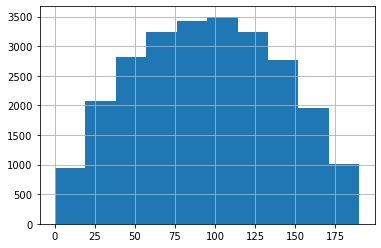

In [23]:
df2_result['true'].hist(bins=10)

<AxesSubplot:>

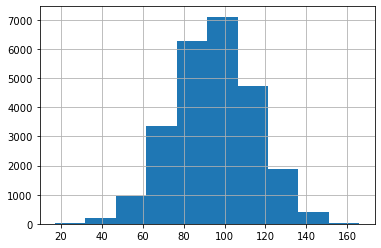

In [24]:
df2_result['predictions'].hist(bins=10)

Несмотря на невысокую разницу в найденных средних, видим, что и фактические распределения различаются, и метрики модели невысоки.

__Вывод:__

Мы видим, что в 1-м и в 3-м регионах R2, RMSE не так хороши, как во 2-м регионе. В то же время средние предсказанные запасы сырья и фактические средние запасы сырья почти совпадают. 

Есть много факторов, которые могли повлиять на R2, RMSE: возможно, это наше ошибочное предположение: согласно данному нам условию задачи мы предположили, что данные имеют линейную зависимость, но это может быть не так.

Также видим, что фактические распределения целевого признака и его предсказаний различаются, что в будущем может означать большую разницу в фактах и предсказаниях на выборке в размере 500 строк, которые мы будем исследовать. 

## Подготовка к расчёту прибыли

По условиям задачи при разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки. Бюджет на разработку скважин в регионе — 10 млрд рублей. При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей. После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбрать регион с наибольшей средней прибылью.

Введем переменные для облегчения изменения расчетов в будущем, если потребуется, сохраним в этих переменных вводные нашей задачи.

In [25]:
total_budget = 10_000_000_000
our_item_qty = 200
item_qty_to_check=500
profit_per_unit = 450_000

total_budget - это наша точка безубыточности. Считаем, что в ней заложены все расходы, требующиеся для разработки скважины, и если мы заработаем с находящегося там сырья такую сумму, мы выйдем в ноль. Считаем, что эта сумма для упрощения расчетов не содержит в себе переменной части (которая на самом деле тем больше, чем больше баррелей добыто из скважины). 

Сколько тысяч баррелей всего мы должны добыть из выбранных 200 скважин, чтобы заработать такую сумму, если считать, что тысяча баррелей приносит нам 450 тысяч рублей? 

In [26]:
units_of_zero_point=(total_budget/profit_per_unit)
units_of_zero_point

22222.222222222223

In [27]:
zero_point_mean_qty=units_of_zero_point/our_item_qty
zero_point_mean_qty

111.11111111111111

In [28]:
list_of_predicted_means=[df0_result.predictions.mean(), df1_result.predictions.mean(), df2_result.predictions.mean()]
print(*list_of_predicted_means)

92.59256778438008 68.72854689544577 94.96504596800504


Если рассчитывать достаточный объём сырья для безубыточной разработки новой скважины и сравнивать полученный объём сырья со средним запасом в каждом регионе, то видим, что ни в одном регионе среднее по скважине не достигает такого значения, однако, это не означает, что в этом регионе нет скважин, у которых фактическое значение больше (конечно же есть) и не означает, что мы не найдем там 200 скважин, которые совместно дадут нам значение прибыли бОльшее, чем наша точка безубыточности. 

## Расчёт прибыли 

Напишем функцию для расчёта прибыли в млн.руб.

In [29]:
def profit_function(df): 
    return (df['predictions'].sum()*profit_per_unit - total_budget)/1_000_000

Выберем в каждом регионе из предсказаний по валидационной выборке случайным образом по 500 значений и выберем 200 с максимальными значениями.  

Зададим параметр случайности выборки 500 скважин из 25 000. 

In [30]:
rndmst=123456789

__Регион №1__

In [31]:
sample0=df0_result.sample(item_qty_to_check, random_state=rndmst).sort_values(by='predictions', ascending=False)[:our_item_qty]
sample0

,f0,f1,f2,predictions,true
50367,1.581559,-0.264143,11.717469,164.518054,139.523593
36874,0.447998,-0.339553,10.635888,154.377462,126.516648
50461,1.296214,-0.440472,9.021662,148.204832,127.079241
52326,0.040041,0.249530,10.943360,146.634102,184.646014
17265,1.902856,0.133431,9.357853,144.510085,40.363713
...,...,...,...,...,...
57866,0.509806,-0.438573,2.103071,99.737230,70.804159
14591,0.163142,1.149015,5.656408,99.537748,89.936340
20165,0.862292,0.228152,3.301657,99.506673,71.265231
68694,1.108527,-0.683091,1.197731,99.366458,123.028638


__Регион №2__

In [32]:
sample1=df1_result.sample(item_qty_to_check, random_state=rndmst).sort_values(by='predictions', ascending=False)[:our_item_qty]
sample1

,f0,f1,f2,predictions,true
20439,-18.822660,-8.256804,4.997382,139.250680,137.945408
60823,-12.060451,-11.454091,5.009029,138.654896,137.945408
80836,-10.788478,-11.757641,5.007238,138.428935,137.945408
34871,-11.649646,-15.907144,4.997861,138.392459,137.945408
11607,-12.260774,-5.873965,5.000257,138.324601,137.945408
...,...,...,...,...,...
91945,-3.740867,-5.867900,2.999385,83.163699,84.038886
26123,-2.134073,-9.281419,3.004093,83.132908,84.038886
4383,-2.670666,-15.181471,2.996181,83.127415,84.038886
78179,-2.478332,-6.532430,3.004102,83.122490,84.038886


__Регион №3__

In [33]:
sample2=df2_result.sample(item_qty_to_check, random_state=rndmst).sort_values(by='predictions', ascending=False)[:our_item_qty]
sample2

,f0,f1,f2,predictions,true
1904,-1.741729,0.575029,13.688761,158.841421,118.772686
30308,-0.094269,-0.759789,12.566898,152.544084,157.465282
1339,-0.631192,-0.217844,10.392351,140.091286,133.443987
85930,-1.191575,-1.241880,10.173281,138.866262,106.531301
7989,0.345417,-0.359158,10.133673,138.650742,107.647665
...,...,...,...,...,...
45022,-4.721336,0.824397,3.477883,100.449571,150.807880
3562,-2.541363,0.998622,3.462415,100.421417,110.942739
23301,1.562955,-1.246168,3.356207,100.036099,35.421518
78104,-0.717426,-0.964634,3.365185,100.005014,97.783916


In [34]:
list_of_loss_profits=[profit_function(sample0), profit_function(sample1), profit_function(sample2)]
list_of_loss_profits

[414.79082787751963, 350.9045007552109, 185.37263153611755]

Покажем предсказанные суммы запасов в выбранных 200 скважинах в регионе, и средние предсказанные запасы в одной скважине)

In [35]:
list_of_predicted_mean=[sample0.predictions.mean(),sample1.predictions.mean(),sample2.predictions.mean()]
list_of_predicted_mean

[115.71989808752792, 115.01005000839125, 113.17080701706796]

In [36]:
list_of_predicted_totals=[sample0.predictions.sum(),sample1.predictions.sum(),sample2.predictions.sum()]
list_of_predicted_totals

[23143.9796175056, 23002.010001678245, 22634.161403413593]

In [37]:
best_region_index=list_of_predicted_mean.index(max(list_of_predicted_mean))
print('Регион с максимальной прибылью от выбранных 200 точек:', list_of_loss_profits.index(max(list_of_loss_profits))+1)

Регион с максимальной прибылью от выбранных 200 точек: 1


Мы определили регион с наилучшей прибылью согласно предсказаниям созданной нами модели.

Для проверки посмотрим, какую прибыль мы бы на самом деле получили, если бы выбрали для разработки эти 200 точек, и получили ли бы ее вообще (в млн.руб). 

In [38]:
true_profit_of_200=(sample0.true.sum()*profit_per_unit - total_budget)/1_000_000
true_profit_of_200

694.9685714743271

Фактическое отличие прибыли от предсказанной было бы в этом случае больше предсказанного на (млн.руб.): 

In [39]:
true_profit_of_200-list_of_loss_profits[0]

280.17774359680743

Это существенная разница. В этом случае, возможно, при другом случайном выборе 500 скважин из 25 000 точек мы бы оказались в такой ситуации, когда получили бы убытки, поэтому перейдем к расчету доверительного интервала и риска убытков, используя Bootstrap на валидационной выборке. 

## Расчёт прибыли и рисков с помощью Bootstrap

Посчитаем риски и прибыль для каждого региона. Для этого: <div>
- применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли, <div>
- найдём среднюю прибыль, 95%-й доверительный интервал и риск убытков, <div>
- выберем регион для разработки скважин после оценки рисков получения убытков после Bootstrap. 

__Регион 1__

Ранее мы обозначили следующие переменные: <div>
- total_budget = 10_000_000_000<div>
- our_item_qty = 200<div>
- item_qty_to_check=500<div>
- profit_per_unit = 450_000

Также нашли zero_point_mean_qty.

Для анализа у нас есть датафреймы с предсказаниями на валидационных выборках: <div>
- df0_result<div>
- df1_result<div>
- df2_result

Также проверим гипотезу о том, что средняя прибыль, полученная нами по результатам Bootstrap больше нуля. 
Сформулируем нулевую гипотезу как "средняя прибыль равняется нулю". 
Альтернативная гипотеза: "средняя прибыль превышает нулевое значение". 

_После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%, и среди них выбрать регион с наибольшей средней прибылью._

In [40]:
def bootstrap_function (df): 

    true = df['true']
    predictions = df['predictions']

    def revenue(true, predictions):
        predictions_sorted = predictions.sort_values(ascending=False)
        selected=true[predictions_sorted.index][:our_item_qty]        
        return (profit_per_unit * selected.sum() - total_budget)

    state = np.random.RandomState(12345)
    
    values = []

    for i in range(1000):
        true_subsample=true.sample(item_qty_to_check, replace=True, random_state=state)
        predictions_subsample=predictions[true_subsample.index]
        values.append(revenue(true_subsample, predictions_subsample))

    values = pd.Series(values)
    bootstaped_mean = values.mean()
    
    interval_95 = (values.quantile(0.025)/1_000_000, values.quantile(0.975)/1_000_000)
    risk_of_loss = (len(values[values<0])/len(values))*100
    
    return (bootstaped_mean, interval_95, risk_of_loss)

In [41]:
print('Регион 1: средняя выручка, млн.руб.', (bootstrap_function(df0_result)[0]/1_000_000))
print('С 95%-й вероятностью средняя выручка находится в интервале, млн.руб.:', bootstrap_function(df0_result)[1])
print('Убытков среди средних значений прибылей, %:', bootstrap_function(df0_result)[-1])

print('Регион 2: средняя выручка, млн.руб.', (bootstrap_function(df1_result)[0]/1_000_000))
print('С 95%-й вероятностью средняя выручка находится в интервале, млн.руб.:', bootstrap_function(df1_result)[1])
print('Убытков среди средних значений прибылей, %:',bootstrap_function(df1_result)[-1])

print('Регион 3: средняя выручка, млн.руб.', (bootstrap_function(df2_result)[0]/1_000_000))
print('С 95%-й вероятностью средняя выручка находится в интервале, млн.руб.:', bootstrap_function(df2_result)[1])
print('Убытков среди средних значений прибылей, %:',bootstrap_function(df2_result)[-1])

Регион 1: средняя выручка, млн.руб. 425.93852691059203
С 95%-й вероятностью средняя выручка находится в интервале, млн.руб.: (-102.09009483793653, 947.9763533583689)
Убытков среди средних значений прибылей, %: 6.0
Регион 2: средняя выручка, млн.руб. 515.2227734432901
С 95%-й вероятностью средняя выручка находится в интервале, млн.руб.: (68.87322537050176, 931.5475912570495)
Убытков среди средних значений прибылей, %: 1.0
Регион 3: средняя выручка, млн.руб. 435.00836278275597
С 95%-й вероятностью средняя выручка находится в интервале, млн.руб.: (-128.880547329789, 969.7069541802662)
Убытков среди средних значений прибылей, %: 6.4


__Вывод:__

Регион 2 с точки зрения оценок, полученных методом Bootstrap, более предпочтителен, т.к. в значениях 95%-й вероятности нет не только отрицательных, но и нулевых, средняя выручка максимальна из трех, и риск убытков менее заданного значения.